# MCTS along priority JIT acceleration

In [2]:
import itertools
import numpy as np
print(np.__version__)
np.random.seed(0)
from tqdm.notebook import trange
from numba import njit
import threading
from concurrent.futures import ThreadPoolExecutor, wait
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import time
import re
from collections import defaultdict
import pprint
import math
from typing import Tuple, List, Set, Callable, NamedTuple, Union, Optional, Iterable, Dict
from multiprocessing import Pool
from sympy import Rational, Integer
from sympy.core.numbers import igcd

import psutil
import os

2.1.3


## Priority Environment

In [3]:
def count_idle_cpus(threshold: float = 10.0) -> int:
    """
    Count CPU cores with usage below the threshold.

    Args:
        threshold (float): Utilization percentage below which a core is considered idle.

    Returns:
        int: Number of idle CPU cores.
    """
    usage: List[float] = psutil.cpu_percent(percpu=True)
    # return sum(1 for u in usage if u < threshold)
    return 1

In [4]:
CPU_CORES = 4

In [5]:
def binomial(n, k):
    if hasattr(math, "comb"):
        return math.comb(n, k)
    # Fallback for Python <3.8
    if 0 <= k <= n:
        num = 1
        denom = 1
        for i in range(1, k+1):
            num *= n - (i - 1)
            denom *= i
        return num // denom
    return 0

class QQ:
    def __init__(self, numerator, denominator=1):
        if denominator == 0:
            raise ZeroDivisionError("Denominator cannot be zero.")
        if not isinstance(numerator, int):
            numerator = Integer(numerator)
        if not isinstance(denominator, int):
            denominator = Integer(denominator)
        g = igcd(numerator, denominator)
        self.num = Integer(numerator // g)
        self.den = Integer(denominator // g)
        if self.den < 0:
            self.num = -self.num
            self.den = -self.den

    def __add__(self, other):
        if not isinstance(other, QQ):
            other = QQ(other)
        num = self.num * other.den + other.num * self.den
        den = self.den * other.den
        return QQ(num, den)

    def __sub__(self, other):
        if not isinstance(other, QQ):
            other = QQ(other)
        num = self.num * other.den - other.num * self.den
        den = self.den * other.den
        return QQ(num, den)

    def __mul__(self, other):
        if not isinstance(other, QQ):
            other = QQ(other)
        return QQ(self.num * other.num, self.den * other.den)

    def __truediv__(self, other):
        if not isinstance(other, QQ):
            other = QQ(other)
        if other.num == 0:
            raise ZeroDivisionError("Division by zero.")
        return QQ(self.num * other.den, self.den * other.num)

    def __neg__(self):
        return QQ(-self.num, self.den)

    def __eq__(self, other):
        if isinstance(other, str):
            return False
        if not isinstance(other, QQ):
            other = QQ(other)
        return self.num == other.num and self.den == other.den

    def __float__(self):
        return float(self.num) / float(self.den)

    def __repr__(self):
        return f"{self.num}/{self.den}" if self.den != 1 else f"{self.num}"
    
    def __hash__(self):
        return hash((self.num, self.den))

    def to_sympy(self):
        return Rational(self.num, self.den)

class Point(NamedTuple):
    """An integer point in 2D space."""
    x: int
    y: int

class Line:
    """
    Represents a line defined by a rational slope and a point on the line.

    Attributes:
        slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
        point (Point): An arbitrary point on the line.
    """

    def __init__(self, slope: Union[QQ, str], point: Point):
        """
        Initialize a line with a given slope and a point on the line.

        Args:
            slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
            point (Point): A point on the line.
        """
        self.slope = slope
        self.point = point

    @classmethod
    def from_points(cls, p1: Point, p2: Point) -> 'Line':
        """
        Construct a line from two points.

        The slope is computed from the two points. The stored point is p1 without any minimization.

        Args:
            p1 (Point): First point.
            p2 (Point): Second point.

        Returns:
            Line: Line through p1 and p2 with p1 stored as the point.
        """
        dx = p2.x - p1.x
        dy = p2.y - p1.y
        if dx == 0:
            slope = 'inf'
        else:
            slope = QQ(dy) / QQ(dx)
        return cls(slope, p1)

    @classmethod
    def from_point_slope_of_line(cls, p: Point, slope: Union[QQ, str]) -> 'Line':
        """
        Construct a line from a point and a slope.

        Args:
            p (Point): A point on the line.
            slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.

        Returns:
            Line: Line defined by the point and slope.
        """
        return cls(slope, p)


def slope_of_line(p1: Point, p2: Point) -> Union[QQ, str]:
    """
    Calculate the slope of the line segment connecting two points.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).

    Returns:
        Union[QQ, str]: The slope as a rational number (QQ) if defined, otherwise the string 'inf' if the line is vertical.
    """
    x1, y1 = p1
    x2, y2 = p2
    dx = x2 - x1
    dy = y2 - y1
    if dx == 0:
        return 'inf'
    return QQ(dy) / QQ(dx)

def are_collinear(p1: Point, p2: Point, p3: Point) -> bool:
    """
    Determine if three points are collinear.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).
        p3 (Point): The third point as a named tuple with integer coordinates (x, y).

    Returns:
        bool: True if the three points are collinear, False otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

def plot_no_three_in_line(points: Iterable[Point], n: Optional[int] = None, title: str = "No-3-in-line Set") -> None:
    """
    Plot a set of points on an n x n grid, illustrating a no-3-in-line configuration.

    Args:
        points (Iterable[Point]): Iterable of points to plot.
        n (Optional[int]): Size of the grid. If None, computed from the points.
        title (str): Title of the plot.

    Returns:
        None
    """
    points = list(points)
    if not points:
        print("No points to plot.")
        return

    xs, ys = zip(*points)
    if n is None:
        n = max(max(xs), max(ys)) + 1

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=100, c='blue', edgecolors='black')
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-1, n)
    plt.ylim(-1, n)
    plt.show()

def find_missing_data(data: Dict[str, Iterable[Tuple[Union[int, str], Union[int, str]]]]) -> Dict[str, Iterable[Tuple[int, Union[int, str]]]]:
    """
    Identify entries with missing data labeled as 'NO DATA' in intervals.

    Args:
        data (Dict[str, Iterable[Tuple[Union[int, str], Union[int, str]]]]): Dictionary mapping keys to iterables of (start, end) intervals.

    Returns:
        Dict[str, Iterable[Tuple[int, Union[int, str]]]]: Dictionary mapping keys to iterables of tuples containing the index of the interval and the start value where 'NO DATA' occurs.
    """
    missing = {}
    for key, intervals in data.items():
        missing_entries = []
        for i, (start, end) in enumerate(intervals):
            if end == 'NO DATA':
                missing_entries.append((i, start))
        if missing_entries:
            missing[key] = missing_entries
    return missing

def points_on_line_pp(p1: Point, p2: Point, grid_size: int) -> Set[Point]:
    """
    Generate points with integer coordinates on the line segment between two points,
    assuming the segment lies on a line with rational slope and intercept.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).

    Returns:
        Set[Point]: Set of points on the line segment from p1 to p2.
    """
    s = slope_of_line(p1, p2)
    if s == 'inf':
        x = p1.x
        return {Point(x, y) for y in range(grid_size) if 0 <= x < grid_size}
    a = s
    b = QQ(p1.y) - a * QQ(p1.x)
    return {Point(x, int(y)) for x in range(grid_size)
            if (y := a * QQ(x) + b).denominator() == 1 and 0 <= y < grid_size}

def points_on_line_l(line: Line, grid_size: int) -> Set[Point]:
    """
    Generate points with integer coordinates on the line defined by the given line object.

    Args:
        line (Line): The line object representing the line.
        grid_size (int): The size of the grid.

    Returns:
        Set[Point]: Set of points on the line within the grid size.
    """
    a = line.slope
    p = line.point
    if a == 'inf':
        x = p.x
        return {Point(x, y) for y in range(grid_size) if 0 <= x < grid_size}
    b = QQ(p.y) - a * QQ(p.x)
    return {Point(x, int(y)) for x in range(grid_size)
            if (y := a * QQ(x) + b).denominator() == 1 and 0 <= y < grid_size}

In [6]:
def __eq__(self, other):
    if isinstance(other, str):
        return False
    if not isinstance(other, QQ):
        other = QQ(other)
    return self.num == other.num and self.den == other.den

In [7]:
def count_points_on_line(p: Point, slope: Union[QQ, str], grid_size: int) -> int:
    """
    Count the number of integer points (excluding point p) on line defined by an intersection point and slope.

    Args:
        p (Point): The given point the line passes through.
        slope (Union[QQ, str): The slope of the line (non-negative), either as a rational number (QQ) or 'inf' for vertical lines.
        grid_size (int): The size of the grid.

    Returns:
        int: The number of integer points on the line.
    """
    if min(p.x, p.y) < 0 or max(p.x, p.y) >= grid_size:
        return 0
    if slope == 'inf' or slope == 0:
        return grid_size - 1

    dy = abs(slope.num)
    dx = abs(slope.den)
    U = math.floor((grid_size - p.x - 1) / dx)
    R = math.floor((grid_size - p.y - 1) / dy)

    D = math.floor(p.x / dx)
    L = math.floor(p.y / dy)
    N_positive = min(U, R) + min(D, L) 
    N_negative = min(U, L) + min(D, R)

    if (N_positive if slope.num > 0 else N_negative) < 0:
        print(f"point: {p}, slope: {slope}")
        print(f"U: {U}, R: {R}, D: {D}, L: {L}, N_positive: {N_positive}, N_negative: {N_negative}")
    return N_positive if slope.num > 0 else N_negative

In [8]:
def _slopes_for_dx_chunk(dx_chunk: List[int], grid_size: int) -> List[QQ]:
    """
    Compute unique slopes for a chunk of dx values within the grid.

    Args:
        dx_chunk (List[int]): A sublist of dx integers to process.
        grid_size (int): The size of the grid.

    Returns:
        List[QQ]: List of unique rational slopes generated from dy/dx pairs in the chunk.
    """
    local_seen = set()
    local_slopes = []
    for dx in dx_chunk:
        for dy in range(1, grid_size):
            s = QQ(dy) / QQ(dx)
            if s not in local_seen:
                local_slopes.append(s)
                local_seen.add(s)
    return local_slopes

def get_possible_slopes(grid_size: int, idle_cores: int = 0) -> Set[Union[QQ, str]]:
    """
    Generate all possible slopes for lines on a grid of given size.

    Args:
        grid_size (int): The size of the grid.
        idle_cores (int): Number of cores to use for parallelism. If <= 1, runs serially.

    Returns:
        Set[Union[QQ, str]]: Set of unique slopes (rational numbers and 'inf' for vertical lines).
    """
    dx_values = list(range(1, grid_size))

    if idle_cores > 1:
        chunk_size = (len(dx_values) + idle_cores - 1) // idle_cores
        chunks = [dx_values[i:i + chunk_size] for i in range(0, len(dx_values), chunk_size)]
        with Pool(idle_cores) as pool:
            results = pool.starmap(_slopes_for_dx_chunk, [(chunk, grid_size) for chunk in chunks])
    else:
        results = [_slopes_for_dx_chunk(dx_values, grid_size)]

    slopes = {QQ(0)}
    for sublist in results:
        for s in sublist:
            slopes.add(s)
            slopes.add(-s)
    slopes.add('inf')
    return slopes


def point_collinear_count(p1: Point, grid_size: int) -> int:
    """
    Count the number of collinear triples on that line including that point (not including horizontal and vertical line).

    Args:
        p1 (Point): The point to check.
        grid_size (int): The size of the grid.

    Returns:
        int: Sum over slopes of binomial(count, 2) for points collinear with p1.
    """
    idle = count_idle_cpus()
    slopes = get_possible_slopes(grid_size, idle_cores=idle)
    counts = sum([
        binomial(count_points_on_line(p1, slope, grid_size), 2)
        for slope in slopes if slope != 0 and slope != 'inf'
    ])
    return counts

# NOISE = random.uniform(-0.1, 0.1) 
NOISE =  0

def collinear_count_priority(n):
    def priority(point):
        return -point_collinear_count(point, n) + NOISE
    return priority

def priority_grid(n):
    """
    Return a 2D numpy array of priority values for each point in an n x n grid.

    Args:
        n (int): The grid size.

    Returns:
        np.ndarray: 2D array of priority values.
    """
    priority_fn = collinear_count_priority(n)
    arr = np.zeros((n, n))
    for x in range(n):
        for y in range(n):
            arr[x, y] = priority_fn(Point(x, y))
    return arr

# Example usage:
# grid = priority_grid(3)
# print(grid)

def heatmap(grid_values: np.ndarray, title: str = "") -> None:
    """
    Plot a heatmap from a 2D numpy array of values and save it to a file named heatmap{n}.png.
    
    Args:
        grid_values (np.ndarray): 2D array of values to plot.
        title (str): Title of the heatmap plot.
    """
    import matplotlib.pyplot as plt

    n = grid_values.shape[0]
    plt.figure(figsize=(6,6))
    plt.imshow(grid_values, origin='lower', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Priority')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.show()

In [9]:
def compute_and_save_priority_grids(priority_grid_fn, size_list=None, output_dir='priority_grids'):
    """
    Compute priority grids for each n in size_list (if not already saved),
    and save them as .npy files in the output_dir directory.

    Parameters:
    - priority_grid_fn: A function to generate the priority grid, which takes n as input.
    - size_list: List of n values to compute.
    - output_dir: Directory where .npy files will be saved.
    """
    # Make sure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for n in size_list:
        # Check if the file already exists
        filename = os.path.join(output_dir, f'priority_grid_{n}.npy')
        if os.path.exists(filename):
            print(f"priority_grid_{n}.npy already exists. Skipping computation.")
            continue  # Skip this n if the file exists

        # Compute the priority grid for the current n
        grid = priority_grid_fn(n)
        
        # Save the grid as a .npy file
        np.save(filename, grid)
        print(f"Saved priority_grid_{n}.npy")


def load_priority_grid(n, input_dir='priority_grids'):
    """
    Load the priority grid numpy array for a given n.

    Parameters:
    - n: The n value of the grid to load.
    - input_dir: Directory containing the .npy files.

    Returns:
    - priority_grid (np.ndarray): The loaded priority grid.
    """
    filename = os.path.join(input_dir, f'priority_grid_{n}.npy')
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File {filename} not found.")
    grid = np.load(filename)
    return grid

n_list = [5, 10, 25]
compute_and_save_priority_grids(priority_grid, size_list=n_list)

priority_grid_5.npy already exists. Skipping computation.
priority_grid_10.npy already exists. Skipping computation.
priority_grid_25.npy already exists. Skipping computation.


In [10]:
load_priority_grid(40)

array([[-2311., -2225., -2171., ..., -2171., -2225., -2311.],
       [-2225., -2216., -2181., ..., -2181., -2216., -2225.],
       [-2171., -2181., -2223., ..., -2223., -2181., -2171.],
       ...,
       [-2171., -2181., -2223., ..., -2223., -2181., -2171.],
       [-2225., -2216., -2181., ..., -2181., -2216., -2225.],
       [-2311., -2225., -2171., ..., -2171., -2225., -2311.]])

## MCTS Environment

In [11]:
@njit(cache=True)
def value_fn_nb(x):
    # return x
    # return np.exp(x)
    return 10.0 ** x

@njit(cache=True)
def get_value_nb(state, pts_upper_bound, value_f=value_fn_nb):
    total = np.sum(state)
    return value_f(total) / value_f(pts_upper_bound)

In [12]:
# JIT-compiled function to check if three points are collinear
@njit(cache=True)
def _are_collinear(x1, y1, x2, y2, x3, y3):
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

# JIT-compiled function to determine valid moves on the board
@njit(cache=True)
def get_valid_moves_nb(state, row_count, column_count):
    max_pts = row_count * column_count
    coords = np.empty((max_pts, 2), np.int64)
    n_pts = 0

    # Collect coordinates of existing points
    for i in range(row_count):
        for j in range(column_count):
            if state[i, j] == 1:
                coords[n_pts, 0] = i
                coords[n_pts, 1] = j
                n_pts += 1

    mask = np.zeros(row_count * column_count, np.uint8)

    # Check each empty cell
    for i in range(row_count):
        for j in range(column_count):
            if state[i, j] != 0:
                continue
            valid = True
            # Check for collinearity with every pair of existing points
            for p in range(n_pts):
                for q in range(p + 1, n_pts):
                    i1, j1 = coords[p, 0], coords[p, 1]
                    i2, j2 = coords[q, 0], coords[q, 1]
                    if _are_collinear(j1, i1, j2, i2, j, i):
                        valid = False
                        break
                if not valid:
                    break
            if valid:
                mask[i * column_count + j] = 1
    return mask

@njit(cache=True)
def get_valid_moves_subset_nb(parent_state, parent_valid_moves, action_taken, row_count, column_count):
    """
    Given a parent state (2D boolean array) and its valid move mask (1D uint8 array),
    return a refined valid move mask for the child:
      1) Remove the action just taken.
      2) For each existing point in state, compute the line to the new point,
         then invalidate any intermediate grid points that lie exactly on that line.
      3) If slope is infinite, invalidate entire column; if slope is zero, invalidate entire row.
    Returns a flattened uint8 array: 1 = valid, 0 = invalid.
    """
    # Copy input mask and remove the taken action
    mask = parent_valid_moves.copy()
    mask[action_taken] = 0

    # Coordinates of the newly placed point
    new_r = action_taken // column_count
    new_c = action_taken % column_count

    # Iterate over all existing points
    for pr in range(row_count):
        for pc in range(column_count):
            if not parent_state[pr, pc]:
                continue
            # Skip the new point itself
            if pr == new_r and pc == new_c:
                continue

            dr = pr - new_r
            dc = pc - new_c

            # Infinite slope (vertical line): invalidate entire column
            if dc == 0:
                for rr in range(row_count):
                    idx = rr * column_count + new_c
                    mask[idx] = 0
                continue

            # Zero slope (horizontal line): invalidate entire row
            if dr == 0:
                row_index = pr
                base = row_index * column_count
                for cc in range(column_count):
                    mask[base + cc] = 0
                continue

            # General (non-vertical, non-horizontal) case: remove every point on the infinite line
            # through (new_r,new_c) and (pr,pc), including both the segment and its extensions.
            for cc in range(column_count):
                # compute how far horizontally from the new point
                num = (cc - new_c) * dr
                # only those aligning to integer row are collinear
                if num % dc != 0:
                    continue
                rr = new_r + num // dc
                # skip anything outside the grid
                if rr < 0 or rr >= row_count:
                    continue
                idx = rr * column_count + cc
                mask[idx] = 0

    return mask

# JIT-compiled function to count collinear triples on the board
@njit(cache=True)
def check_collinear_nb(state, row_count, column_count):
    max_pts = row_count * column_count
    coords = np.empty((max_pts, 2), np.int64)
    n_pts = 0

    # Collect all placed point coordinates
    for i in range(row_count):
        for j in range(column_count):
            if state[i, j] == 1:
                coords[n_pts, 0] = i
                coords[n_pts, 1] = j
                n_pts += 1

    triples = 0
    # Count all collinear triplets
    for a in range(n_pts):
        for b in range(a + 1, n_pts):
            for c in range(b + 1, n_pts):
                i1, j1 = coords[a, 0], coords[a, 1]
                i2, j2 = coords[b, 0], coords[b, 1]
                i3, j3 = coords[c, 0], coords[c, 1]
                if _are_collinear(j1, i1, j2, i2, j3, i3):
                    triples += 1
    return triples


# JIT-compiled function to perform a full random rollout until terminal
@njit(cache=True)
def simulate_nb(state, row_count, column_count, pts_upper_bound):
    """
    Perform random rollout until no valid moves remain.
    Return normalized value using a custom value function.
    Uses get_valid_moves_subset_nb for incremental validity updates.
    """
    max_size = row_count * column_count
    # Initial valid moves mask
    valid_moves = get_valid_moves_nb(state, row_count, column_count)
    total_valid = np.sum(valid_moves)

    while total_valid > 0:
        # Build list of valid actions



        acts = np.empty(total_valid, np.int64)
        k = 0
        for idx in range(max_size):
            if valid_moves[idx]:
                acts[k] = idx
                k += 1
        # Randomly select one valid action and place the point
        pick = acts[np.random.randint(0, total_valid)]

        # Incrementally update valid_moves using subset-based filtering
        valid_moves = get_valid_moves_subset_nb(
            state,
            valid_moves,
            pick,
            row_count,
            column_count
        )

        r = pick // column_count
        c = pick % column_count
        state[r, c] = 1  # mark the new point

        total_valid = np.sum(valid_moves)

    # Compute and return the final value
    return get_value_nb(state, pts_upper_bound)


class N3il:
    def __init__(self, grid_size, args, priority_grid=None):
        self.row_count, self.column_count = grid_size
        self.pts_upper_bound = np.min(grid_size) * 2
        self.action_size = self.row_count * self.column_count
        self.args = args
        self.priority_grid = priority_grid  # Store priority grid

    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count), np.uint8)

    def get_next_state(self, state, action):
        row = action // self.column_count
        col = action % self.column_count
        state[row, col] = 1
        return state

    def get_valid_moves(self, state):
        # Get all valid moves
        valid_moves = get_valid_moves_nb(state, self.row_count, self.column_count)
        # Only keep moves with the highest priority
        if self.priority_grid is not None:
            indices = np.where(valid_moves == 1)[0]
            if len(indices) == 0:
                return valid_moves
            priorities = np.array([self.priority_grid[idx // self.column_count, idx % self.column_count] for idx in indices])
            max_priority = np.max(priorities)
            max_indices = indices[priorities == max_priority]
            mask = np.zeros_like(valid_moves)
            mask[max_indices] = 1
            return mask
        else:
            return valid_moves

    def get_valid_moves_subset(self, parent_state, parent_valid_moves, action_taken):
        # Get all valid moves
        valid_moves = get_valid_moves_subset_nb(parent_state, parent_valid_moves, action_taken, self.row_count, self.column_count)
        # Only keep moves with the highest priority
        if self.priority_grid is not None:
            indices = np.where(valid_moves == 1)[0]
            if len(indices) == 0:
                return valid_moves
            priorities = np.array([self.priority_grid[idx // self.column_count, idx % self.column_count] for idx in indices])
            max_priority = np.max(priorities)
            max_indices = indices[priorities == max_priority]
            mask = np.zeros_like(valid_moves)
            mask[max_indices] = 1
            return mask
        else:
            return valid_moves

    def check_collinear(self, state, action=None):
        if action is not None:
            temp_state = state.copy()
            row = action // self.column_count
            col = action % self.column_count
            temp_state[row, col] = 1
        else:
            temp_state = state

        # Call numba-accelerated function
        return check_collinear_nb(temp_state, self.row_count, self.column_count)

    def get_value_and_terminated(self, state, valid_moves):
        """
        Return the normalized value and terminal status of the current state.
        Delegates value calculation to get_value_nb().
        """
        if np.sum(valid_moves) > 0:
            return 0.0, False

        value = get_value_nb(state, self.pts_upper_bound)
        return value, True
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

    def display_state(self, state, action_prob=None):
        """
        Display the current grid configuration using matplotlib.
        Points are drawn where the state equals 1.
        The origin (0, 0) is located at the bottom-left.
        If action_prob is provided (1D array), it is reshaped and overlaid as a heatmap.
        """
        plt.figure(figsize=(10, 10))
        ax = plt.gca()

        if action_prob is not None:
            assert action_prob.shape[0] == self.row_count * self.column_count, \
                f"Expected length {self.row_count * self.column_count}, got {len(action_prob)}"
            action_prob_2d = action_prob.reshape((self.row_count, self.column_count))
            flipped_probs = np.flipud(action_prob_2d)

            im = ax.imshow(
                flipped_probs,
                cmap='Reds',
                alpha=0.6,
                extent=[-0.5, self.column_count - 0.5, -0.5, self.row_count - 0.5],
                origin='lower',
                vmin=0, vmax=np.max(action_prob) if np.max(action_prob) > 0 else 1e-5
            )
            plt.colorbar(im, label="Action Probability", shrink=0.8)

            # Find maximum probability
            max_val = np.max(action_prob_2d)
            max_positions = np.argwhere(action_prob_2d == max_val)

            # Add text annotations for probabilities
            for i in range(self.row_count):
                for j in range(self.column_count):
                    val = action_prob_2d[i, j]
                    display_y = self.row_count - 1 - i  # Flip vertically
                    is_max = any((i == mp[0] and j == mp[1]) for mp in max_positions)
                    ax.text(
                        j, display_y, f"{val:.3f}",
                        ha="center", va="center",
                        color="gold" if is_max else ("black" if val < 0.5 * max_val else "white"),
                        weight='bold' if is_max else 'normal',
                        fontsize=6
                    )

        # Plot placed points
        y_coords, x_coords = np.nonzero(state)
        flipped_y = self.row_count - 1 - y_coords
        plt.scatter(x_coords, flipped_y, s=20, c='blue', label='Placed Points')

        plt.grid(True)
        plt.xticks(range(self.column_count))
        plt.yticks(range(self.row_count))
        plt.xlim(-0.5, self.column_count - 0.5)
        plt.ylim(-0.5, self.row_count - 0.5)
        ax.set_aspect('equal')
        plt.title("No-Three-In-Line Grid with Action Probabilities" if action_prob is not None else "No-Three-In-Line Grid")
        plt.show()

'''
Adapt from
foersterrobert/AlphaZeroFromScratch
'''

class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken

        self.children = []
        self.visit_count = 0
        self.value_sum = 0
        self.lock = threading.Lock()
        self._vl = args.get('virtual_loss', 1.0)

        if parent is None:
            self.valid_moves = game.get_valid_moves(state)
        else:
            self.valid_moves = game.get_valid_moves_subset(
                parent.state, parent.valid_moves, self.action_taken)

        self.is_full = False
        self._cached_ucb = None     # Cached UCB value
        self._ucb_dirty = True      # Indicates whether the cached UCB is stale

    def apply_virtual_loss(self):
        with self.lock:
            self.value_sum -= self._vl
            self.visit_count += 1
            self._ucb_dirty = True  # Mark UCB as outdated

    def revert_virtual_loss(self):
        with self.lock:
            self.value_sum += self._vl
            self._ucb_dirty = True  # Mark UCB as outdated

    def is_fully_expanded(self):
        return self.is_full and len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf
        log_N = math.log(self.visit_count)

        for child in self.children:
            ucb = self.get_ucb(child, log_N)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child, log_N=None):
        if log_N is None:
            log_N = math.log(self.visit_count)

        with child.lock:
            if not child._ucb_dirty and child._cached_ucb is not None:
                return child._cached_ucb

            q_value = child.value_sum / child.visit_count
            ucb = q_value + self.args['C'] * math.sqrt(log_N / child.visit_count)
            child._cached_ucb = ucb
            child._ucb_dirty = False
            return ucb

    def expand(self):
        valid_indices = np.where(self.valid_moves == 1)[0]
        action = np.random.choice(valid_indices)
        self.valid_moves[action] = 0

        if np.sum(self.valid_moves) == 0:
            self.is_full = True

        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action)

        child = Node(self.game, self.args, child_state, self, action)
        self.children.append(child)
        return child

    def simulate(self):
        tmp = self.state.copy()
        return simulate_nb(tmp,
                           self.game.row_count,
                           self.game.column_count,
                           self.game.pts_upper_bound)

    def backpropagate(self, value):
        with self.lock:
            self.value_sum += value
            self._ucb_dirty = True  # Mark UCB as outdated
        self.visit_count += 1
        if self.parent is not None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, game, args={
        'num_searches': 1000,
        'C': 1.4
    }):
        self.game = game
        self.args = args

    def search(self, state):
        # define root
        root = Node(self.game, self.args, state)

        if self.args['process_bar'] == True:
            search_iterator = trange(self.args['num_searches'])
        else:
            search_iterator = range(self.args['num_searches'])

        for search in search_iterator:
            node = root

            # selection
            while node.is_fully_expanded():
                node = node.select()

            if node.action_taken is not None:
                value, is_terminal = self.game.get_value_and_terminated(node.state, node.valid_moves)
                # has_collinear = self.game.check_collinear(node.state, node.action_taken)
                # value, _ = self.game.get_value_and_terminated(node.state)

                if not is_terminal:
                    node = node.expand()
                    value = node.simulate()
            else:
                node = node.expand()
                value = node.simulate()

            node.backpropagate(value)

        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
            
            # expansion
            # simulation
            # backpropagation

        # return visit_counts

class ParallelMCTS(MCTS):
    def __init__(self, game, args):
        super().__init__(game, args)
        self.num_workers   = args.get('num_workers', 4)
        self.virtual_loss  = args.get('virtual_loss', 1.0)
        self.args = args

    # --- single simulation --------------------------------------------------
    def _search_once(self, root):
        path = []
        node = root

        # 1. SELECTION
        while node.is_fully_expanded():
            path.append(node)
            node.apply_virtual_loss()         # <‑‑ reserve
            node = node.select()

        # 2. EXPANSION / SIMULATION
        if node.action_taken is None:
            node = node.expand()
        path.append(node)
        node.apply_virtual_loss()             # reserve leaf
        value = node.simulate() if not self.game.get_value_and_terminated(
            node.state, node.valid_moves
        )[1] else self.game.get_value_and_terminated(
            node.state, node.valid_moves
        )[0]

        # 3. UNDO VIRTUAL LOSS + BACKPROP
        for n in path:
            n.revert_virtual_loss()
        node.backpropagate(value)
    # ------------------------------------------------------------------------

    # --- parallel driver ----------------------------------------------------
    def search(self, state):
        root = Node(self.game, self.args, state)

        sims_per_worker = self.args['num_searches'] // self.num_workers
        remainder       = self.args['num_searches'] %  self.num_workers

        def worker(n_sims):
            if self.args['process_bar'] == True:
                for _ in trange(n_sims):
                    self._search_once(root)
            else:
                for _ in range(n_sims):
                    self._search_once(root)

        with ThreadPoolExecutor(max_workers=self.num_workers) as pool:
            futures = [pool.submit(worker, sims_per_worker)
                       for _ in range(self.num_workers)]
            if remainder:                     # handle leftovers
                futures.append(pool.submit(worker, remainder))
            wait(futures)

        # convert visit counts → prob. vector
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs


def select_outermost_with_tiebreaker(mcts_probs, n):
    """
    Select an action from the outermost positions among those with the highest MCTS probability.
    If multiple actions have the same max probability and distance to edge, break ties randomly.
    """
    # Reshape the 1D probability array to 2D grid
    mcts_probs_2d = mcts_probs.reshape((n, n))
    max_val = np.max(mcts_probs_2d)

    # Find all positions with maximum probability
    max_indices = np.argwhere(mcts_probs_2d == max_val)

    # Define distance to nearest board edge
    def edge_distance(i, j):
        return min(i, n - 1 - i, j, n - 1 - j)

    # Compute edge distance for each candidate
    distances = [edge_distance(i, j) for i, j in max_indices]
    min_dist = min(distances)

    # Select all actions with minimum edge distance
    outermost_positions = [pos for pos, dist in zip(max_indices, distances) if dist == min_dist]

    # Break ties randomly among outermost positions
    chosen_pos = outermost_positions[np.random.choice(len(outermost_positions))]
    action = chosen_pos[0] * n + chosen_pos[1]
    return action

def evaluate(args):
    priority_grid_arr = load_priority_grid(args['n'])
    start = time.time()
    n = args['n']
    # Pass priority_grid to N3il
    n3il = N3il(grid_size=(n, n), args=args, priority_grid=priority_grid_arr)

    mcts_cls = ParallelMCTS if args.get('num_workers', 1) > 1 else MCTS
    mcts = mcts_cls(n3il, args=args)

    state = n3il.get_initial_state()
    num_of_points = 0

    while True:
        if args['display_state'] == True:
            print("---------------------------")
            print(f"Number of points: {num_of_points}")
            print(state)

        valid_moves = n3il.get_valid_moves(state)
        value, is_terminal = n3il.get_value_and_terminated(state, valid_moves)

        if is_terminal:
            print("*******************************************************************")
            print(f"Trial Terminated with {num_of_points} points. Final valid configuration:")
            print(state)
            n3il.display_state(state, mcts_probs)
            end = time.time()
            print(f"Time: {end - start:.6f} sec")
            break

        # Get MCTS probabilities
        mcts_probs = mcts.search(state)

        # Use outermost-priority selector to pick action
        action = select_outermost_with_tiebreaker(mcts_probs, n)

        # Display MCTS probabilities and board
        if args['display_state'] == True:
            n3il.display_state(state, mcts_probs)

        # Apply action
        num_of_points += 1
        state = n3il.get_next_state(state, action)
    
    if args['logging_mode'] == True:
        return num_of_points

## Test

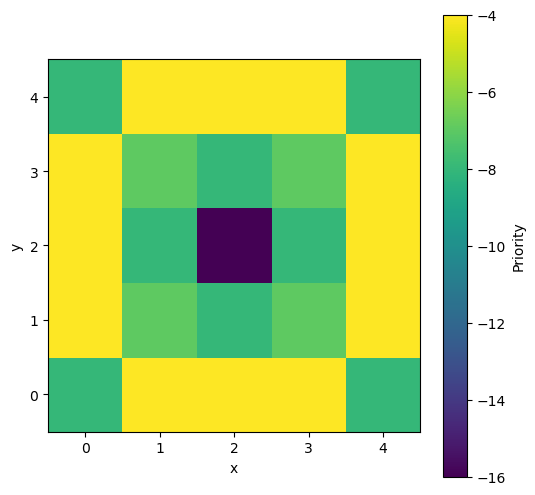

In [13]:
heatmap(load_priority_grid(5))

---------------------------
Number of points: 0
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

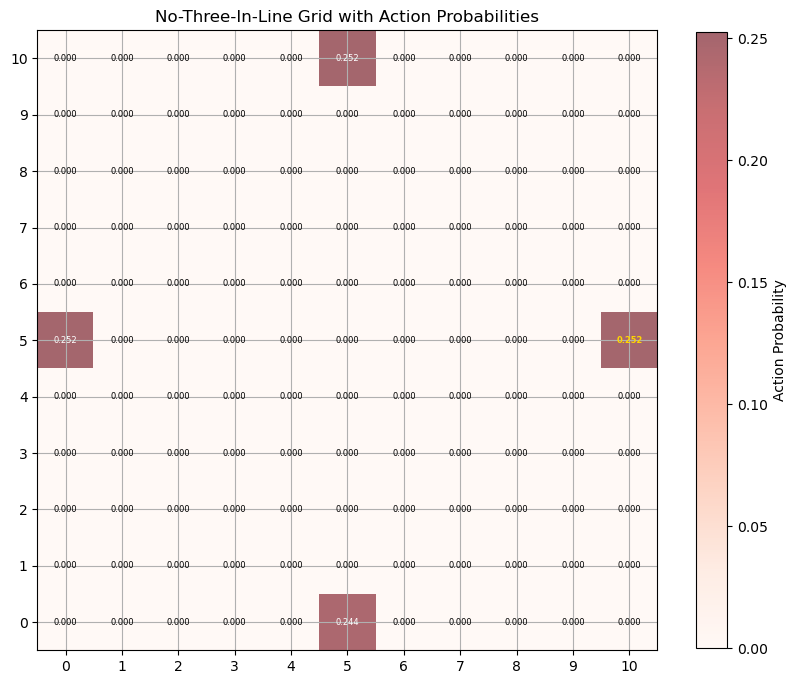

---------------------------
Number of points: 1
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

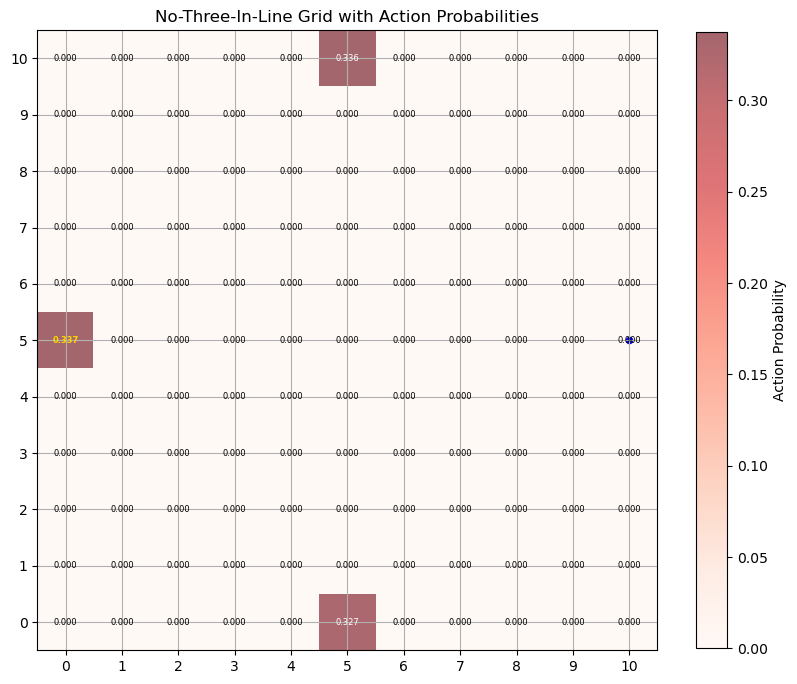

---------------------------
Number of points: 2
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

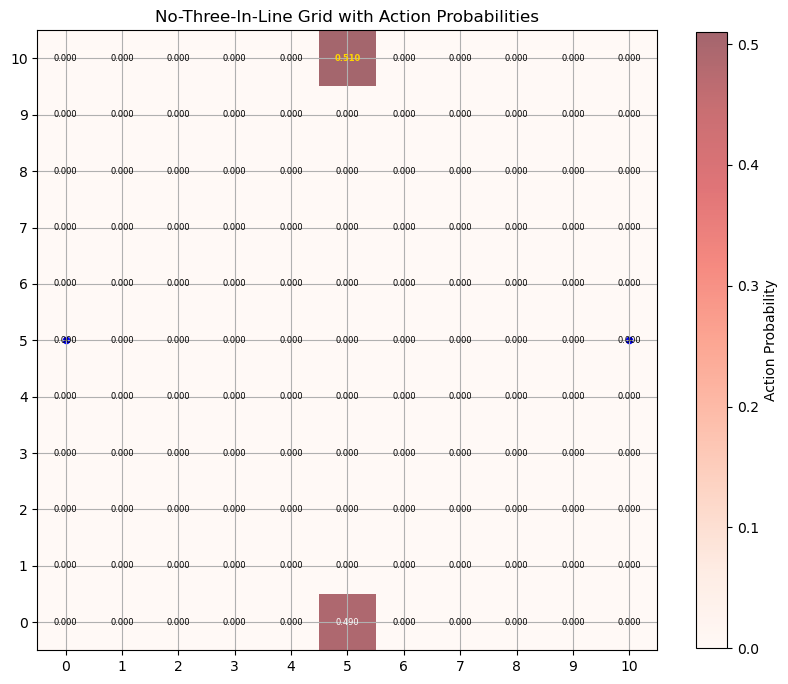

---------------------------
Number of points: 3
[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

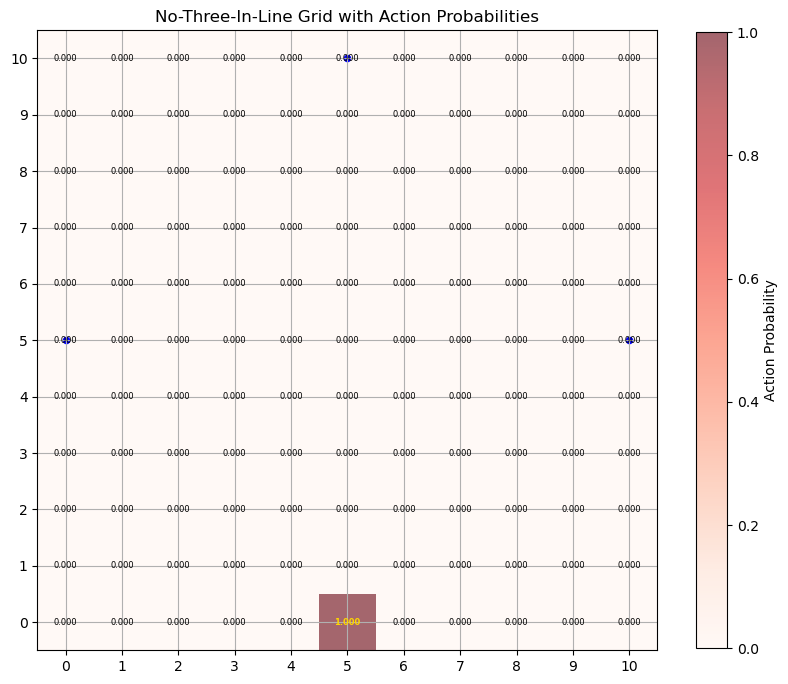

---------------------------
Number of points: 4
[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

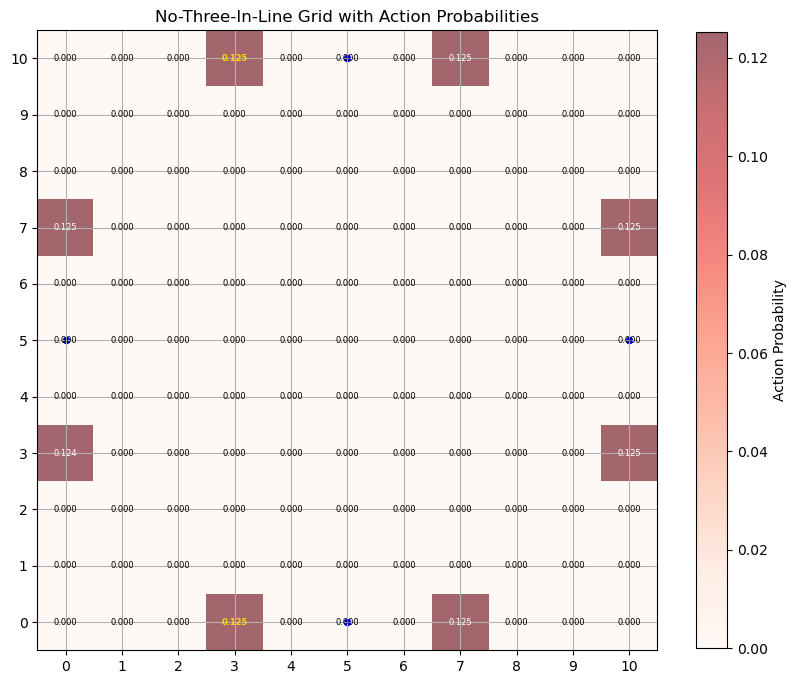

---------------------------
Number of points: 5
[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

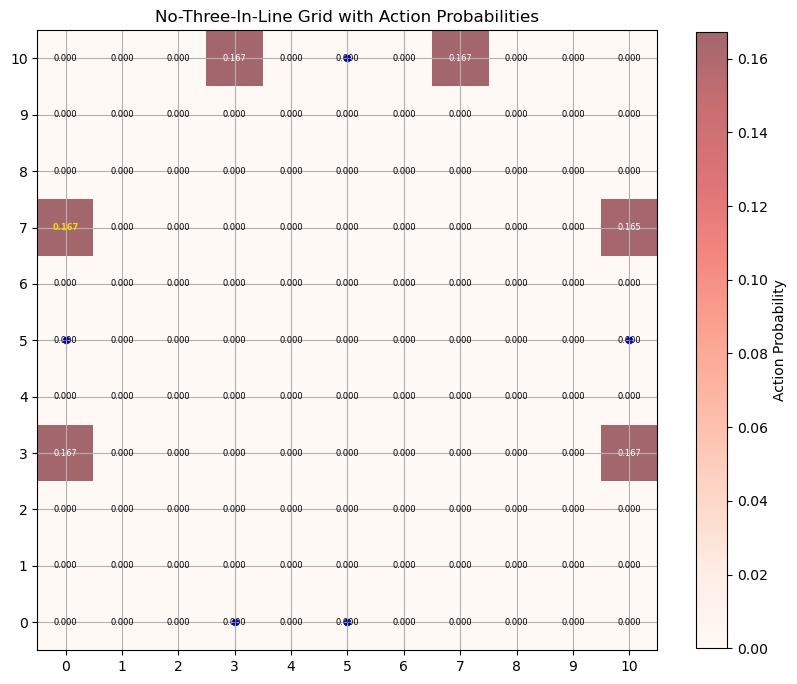

---------------------------
Number of points: 6
[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

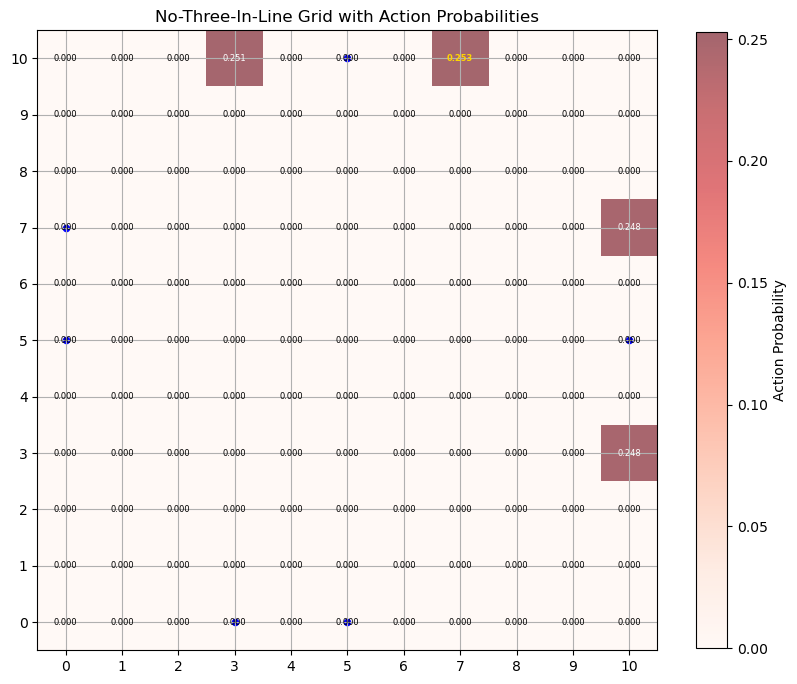

---------------------------
Number of points: 7
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

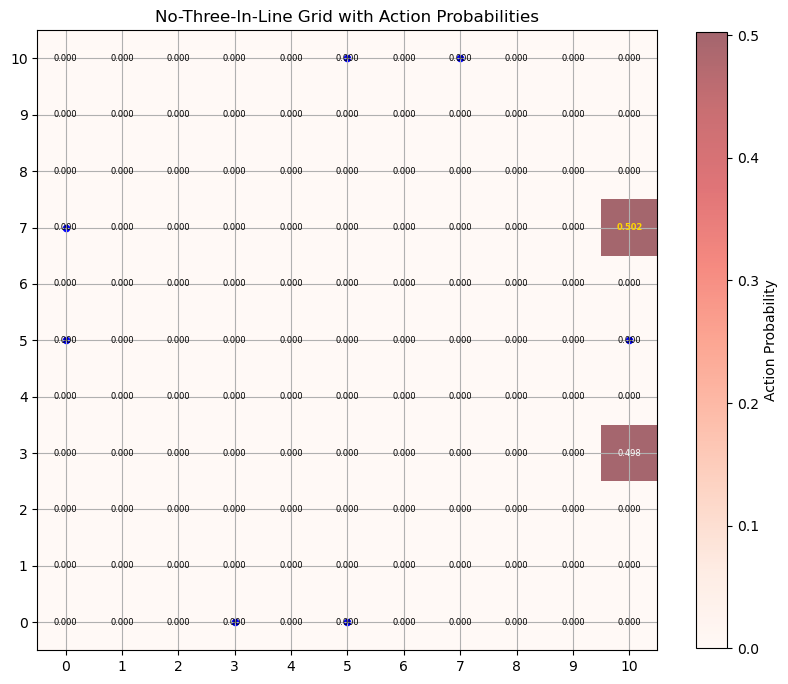

---------------------------
Number of points: 8
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

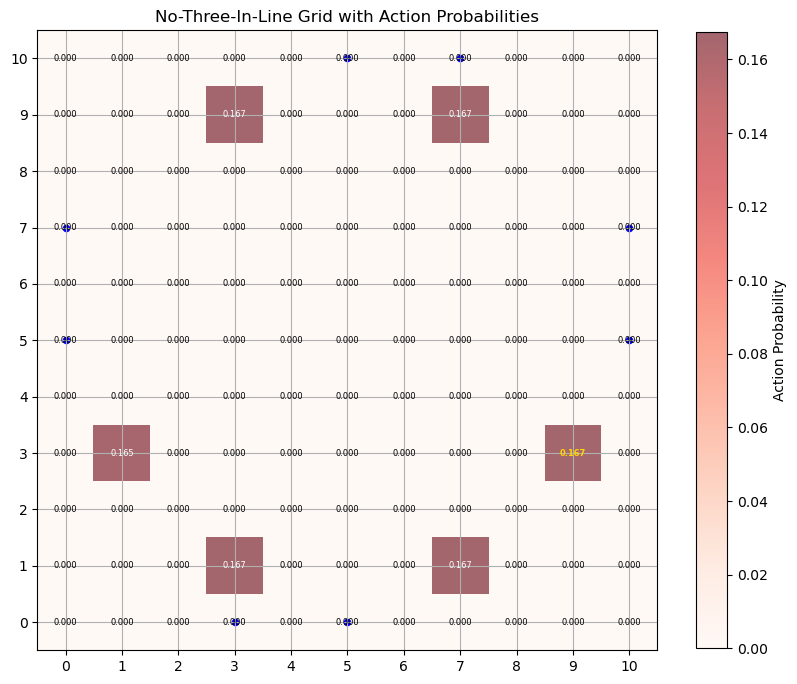

---------------------------
Number of points: 9
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

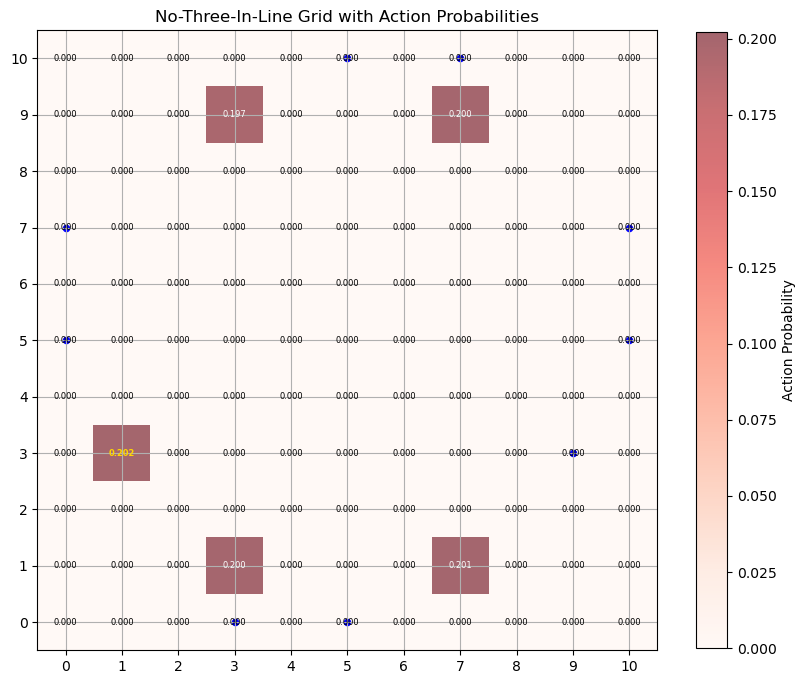

---------------------------
Number of points: 10
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

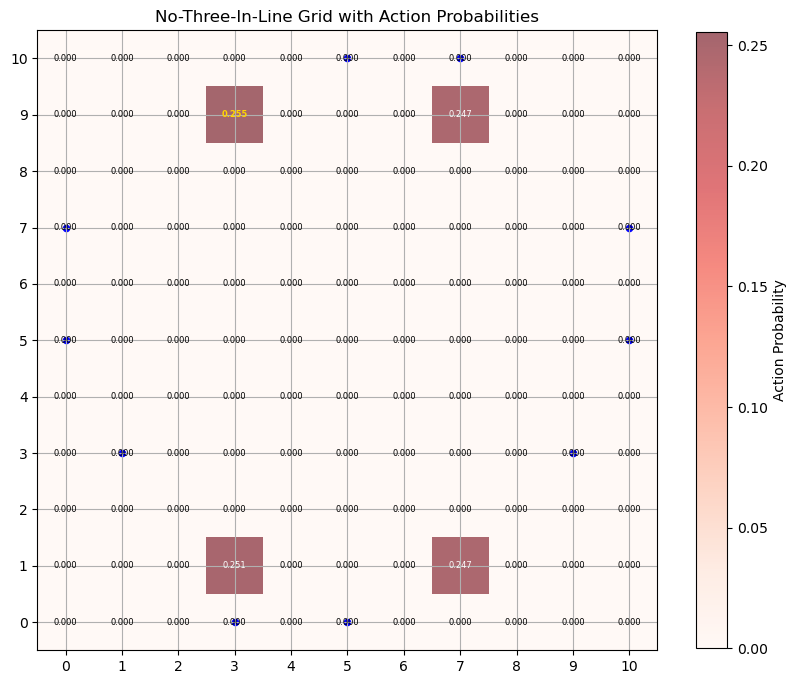

---------------------------
Number of points: 11
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

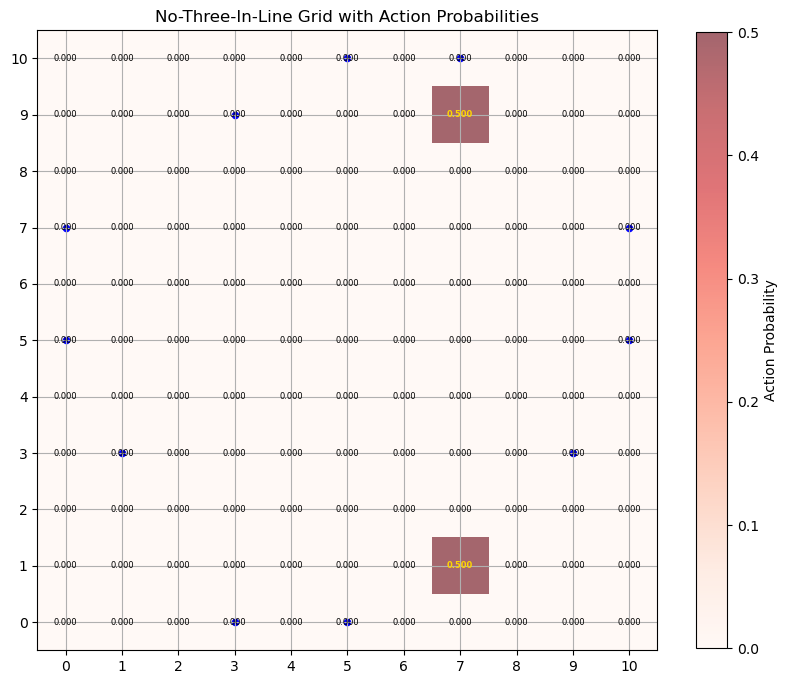

---------------------------
Number of points: 12
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

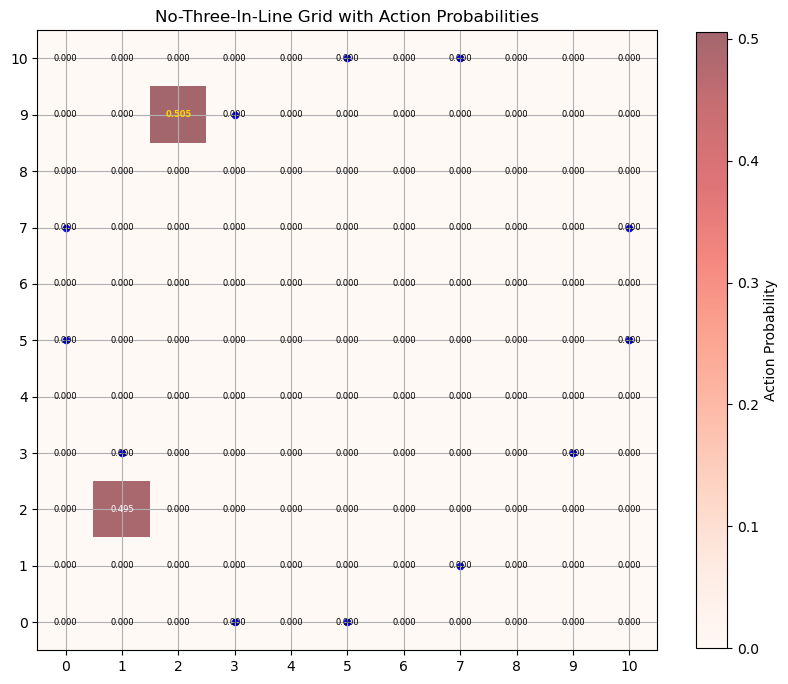

---------------------------
Number of points: 13
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

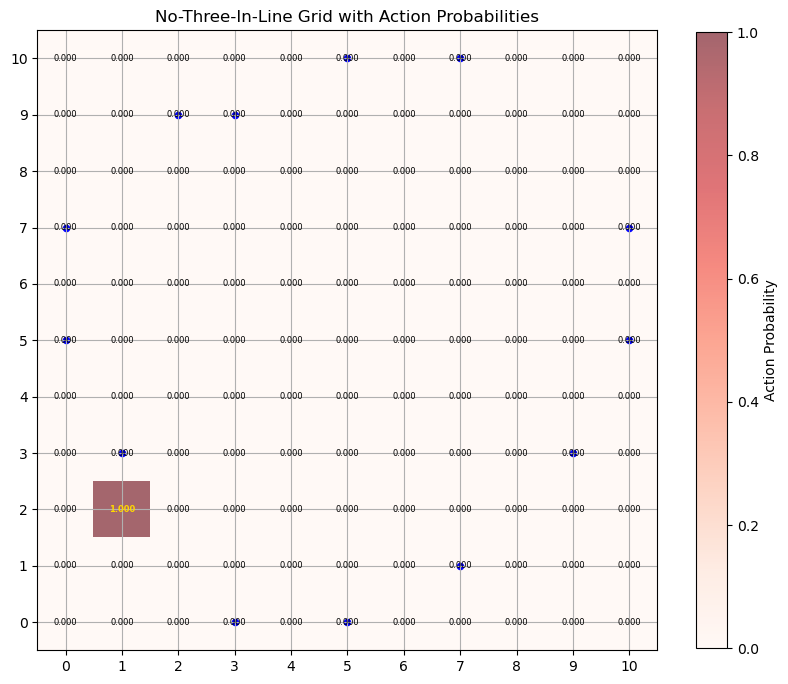

---------------------------
Number of points: 14
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

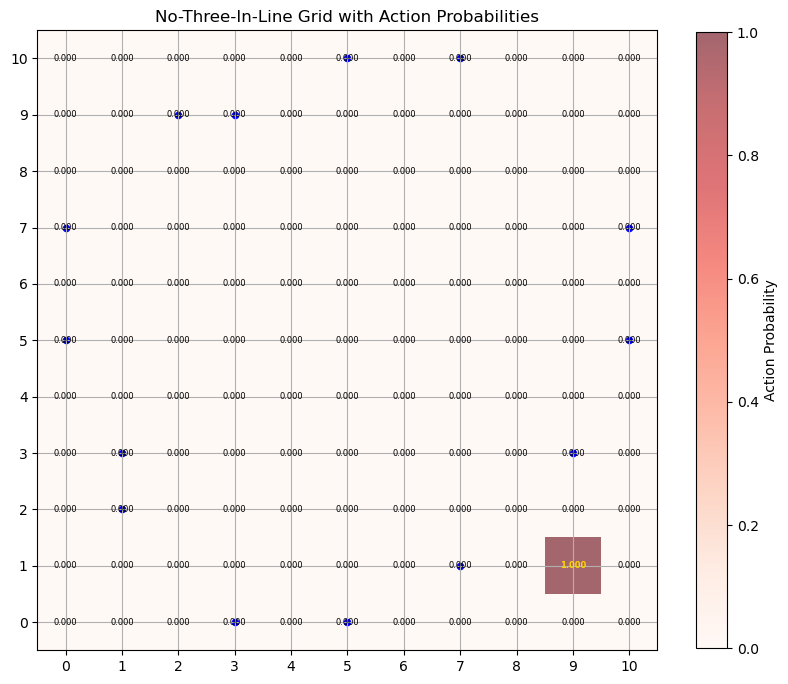

---------------------------
Number of points: 15
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

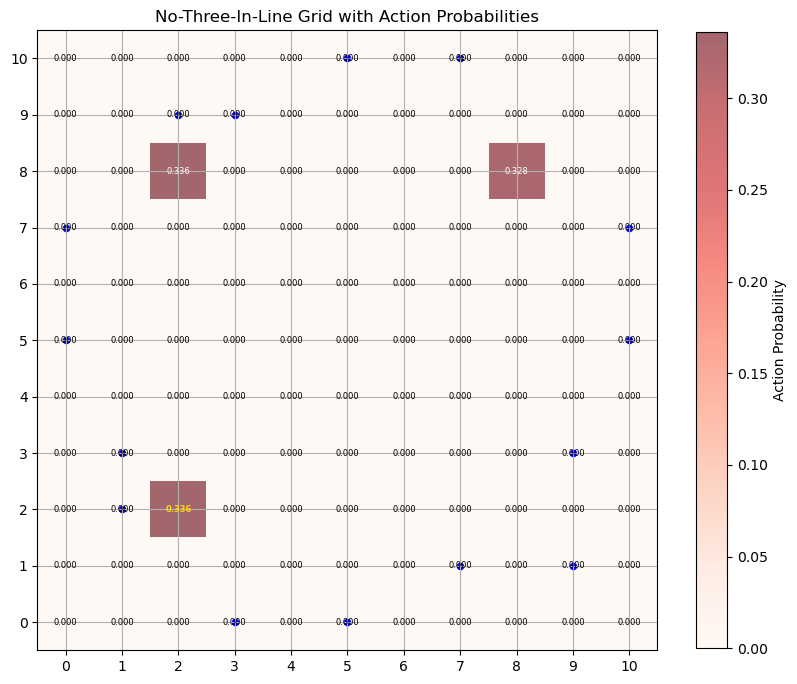

---------------------------
Number of points: 16
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

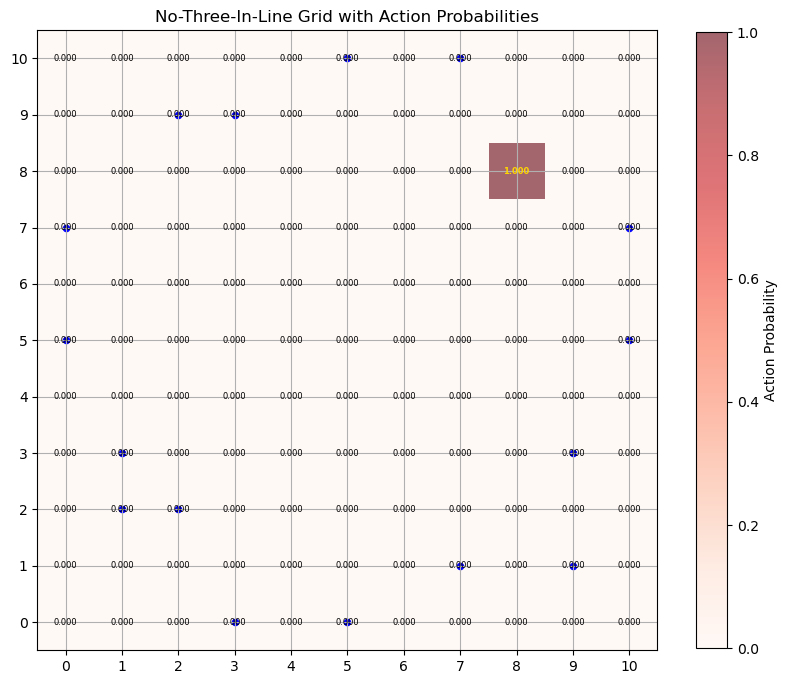

---------------------------
Number of points: 17
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

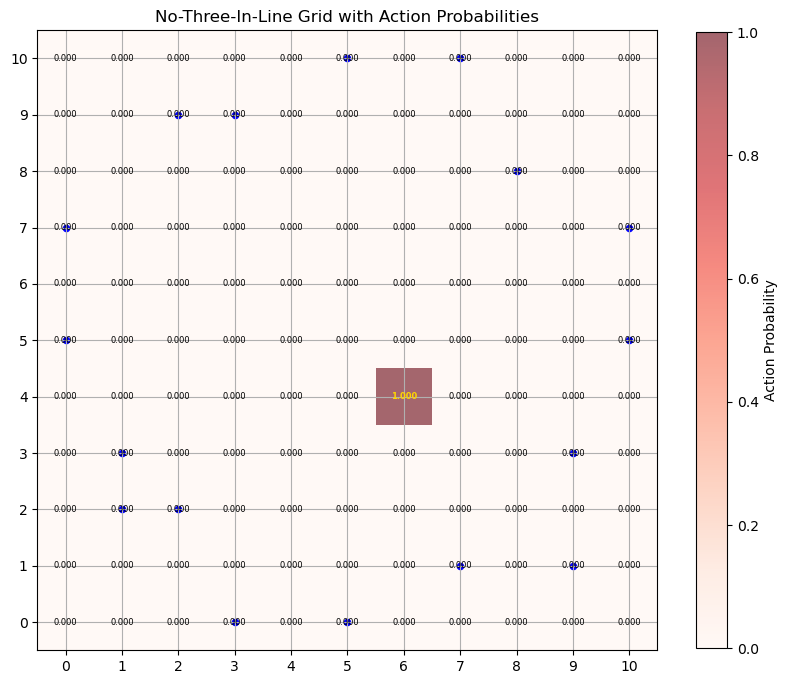

---------------------------
Number of points: 18
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0 0 0 0 0]]
*******************************************************************
Trial Terminated with 18 points. Final valid configuration:
[[0 0 0 0 0 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0 0 0 0 0]]


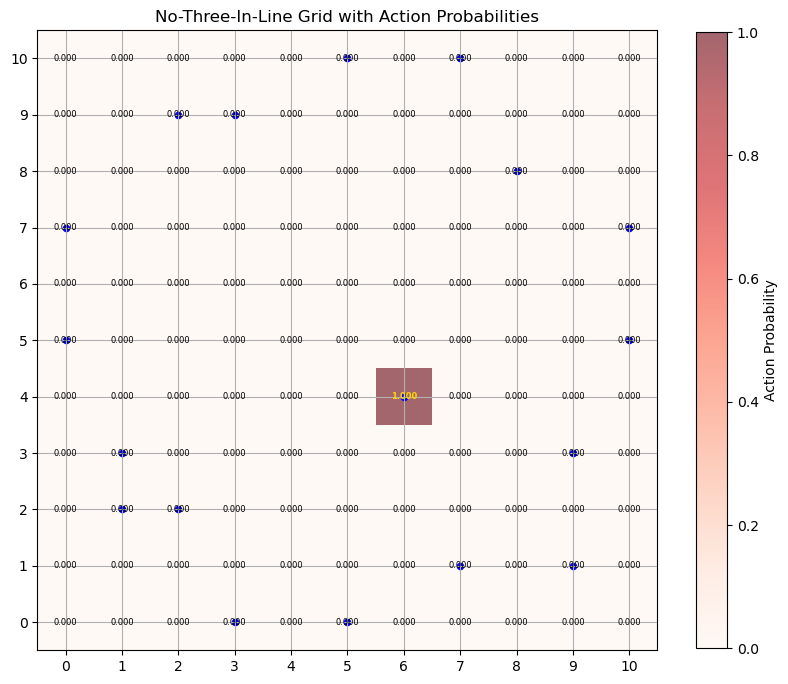

Time: 59.757503 sec


In [17]:
np.random.seed(0)

args = {
        'n': 11,
        'C': 0.2,
        'num_searches': 40_000,
        'num_workers'  : 4,      # >1 ⇒ parallel
        'virtual_loss' : 1.0,     # magnitude to subtract at reservation
        'process_bar' : True,
        'display_state' : True,
        'logging_mode' : False
    }

evaluate(args)

### Plot

*******************************************************************
Trial Terminated with 50 points. Final valid configuration:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


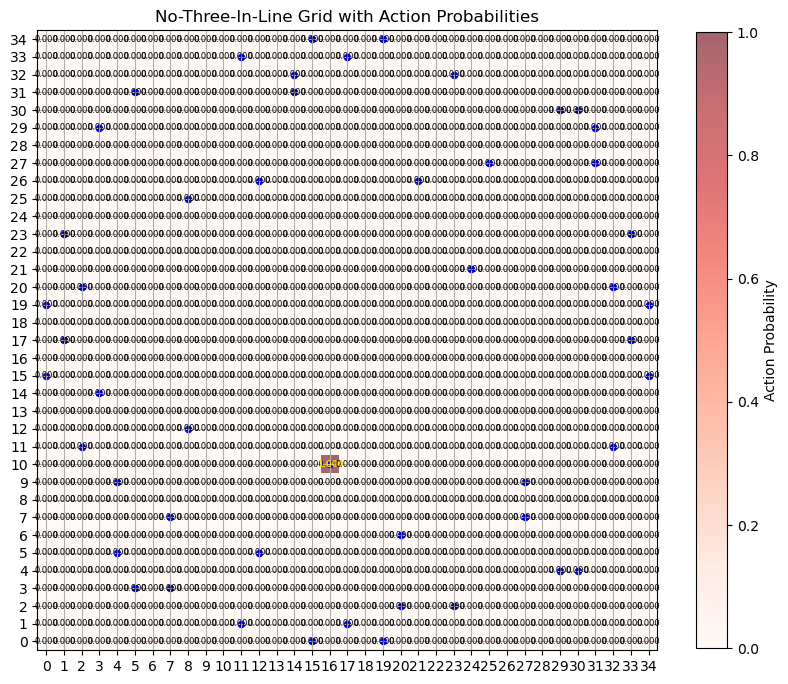

Time: 6339.054020 sec


In [ ]:
np.random.seed(0)

n_list = np.arange(5,55,5)

result_list = []

for n in n_list:

    args = {
            'n': n,
            'C': 0.2,
            'num_searches': 10_000,
            'num_workers'  : 4,      # >1 ⇒ parallel
            'virtual_loss' : 1.0,     # magnitude to subtract at reservation
            'process_bar' : False,
            'display_state' : False,
            'logging_mode' : True
        }

    number_of_points = evaluate(args)

    result_list.append((n, number_of_points))

print(result_list)

In [ ]:
result_arr = np.array(result_list)

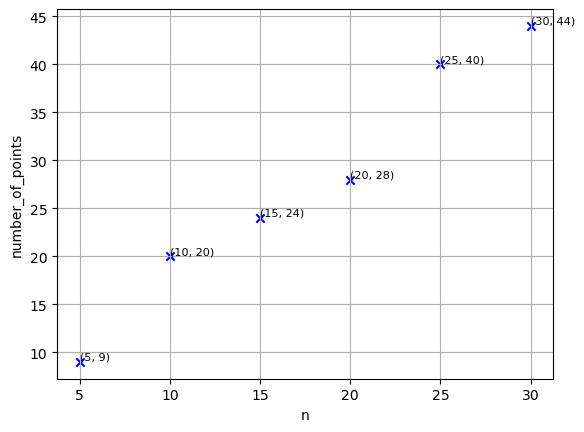

In [ ]:
plt.scatter(result_arr[:, 0], result_arr[:, 1], marker='x', color='blue')

for x, y in result_arr:
    plt.text(x, y, f'({x}, {y})', ha='left', va='bottom', fontsize=8)

plt.xlabel('n')
plt.ylabel('number_of_points')
plt.grid(True)
plt.show()